# This script processes the o2par results (tbb version of qmin) now with indices to point to the cloud and parallel tree

1. Compile o2par with:
```
make bin/o2par
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_optim2
```
3. The output that we will process is o2_parallel_coffee.txt (renamed from o2parallel.out)


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize1(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[2].split("/")[3][:-1]
                else:
                    name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                if name not in experiment:
                    experiment[name]={}
            if 'Quadtree' in tokens:
                experiment[name][nth]=[float(tokens[5])]
            if "STAGE" in tokens:
                experiment[name][nth].append(float(tokens[5]))
            if 'Average:' in tokens:
                experiment[name][nth].append(float(tokens[1]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            results[i][j]['qtree']=experiment[i][j][0]
            results[i][j]['stage1']=mean(experiment[i][j][1:16:3])
            results[i][j]['stage2']=mean(experiment[i][j][2:16:3])
            results[i][j]['stage3']=mean(experiment[i][j][3:16:3])
            results[i][j]['owm']=experiment[i][j][16]
    return results

def tokenize2(filename,noH=False):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                if noH:
                    name=tokens[2].split("/")[3][:-1]
                else:
                    name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                level=int(tokens[9])
                if name not in experiment:
                    experiment[name]={}
                if level not in experiment[name]:
                    experiment[name][level]={}
                if nth not in experiment[name][level]:
                    experiment[name][level][nth]=[]
            if "STAGE" in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Quadtree' in tokens:
                experiment[name][level][nth].append(float(tokens[5]))
            if 'Average' in tokens:
                experiment[name][level][nth].append(float(tokens[2]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            for k in experiment[i][j]:
                results[i][j][k]={}
                results[i][j][k]['qtree']=experiment[i][j][k][15]
                results[i][j][k]['stage1']=mean(experiment[i][j][k][0:15:3])
                results[i][j][k]['stage2']=mean(experiment[i][j][k][1:15:3])
                results[i][j][k]['stage3']=mean(experiment[i][j][k][2:15:3])
                results[i][j][k]['owm']=experiment[i][j][k][16]
    return results

res1=tokenize1("o1_qtree_coffee.txt")
res2=tokenize1("o2_parallel_coffee.txt",True) # optim2 without parallel tree construction
res4=tokenize2("o2_partree_coffee.txt",True)  # optim2 with parallel tree construction


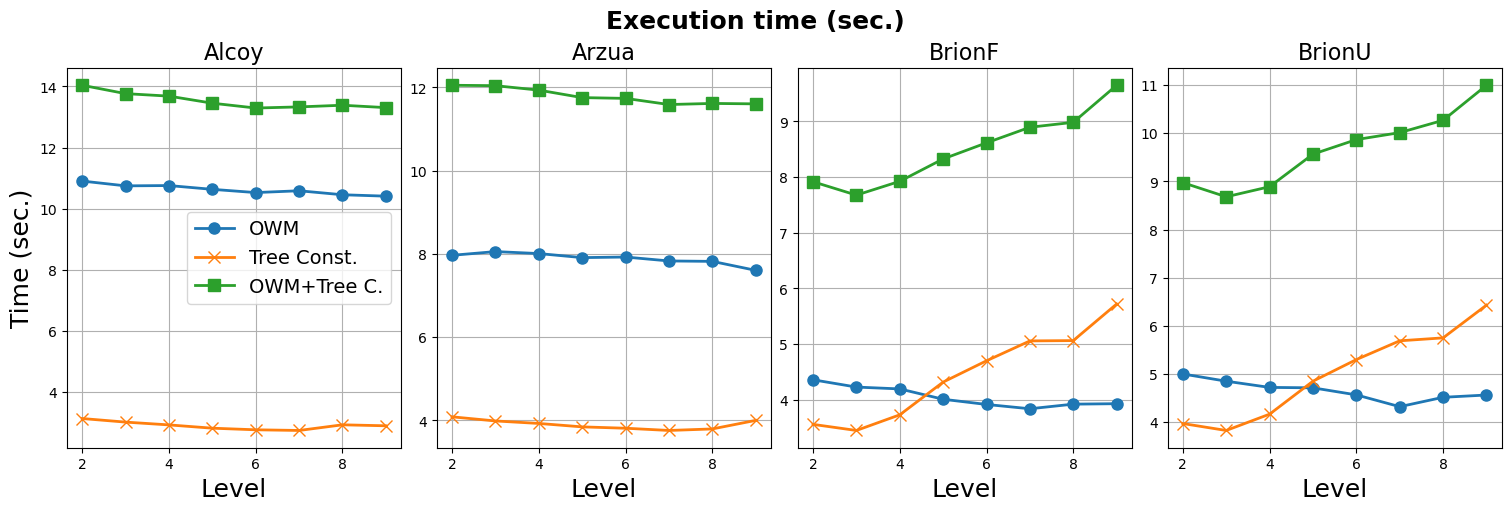

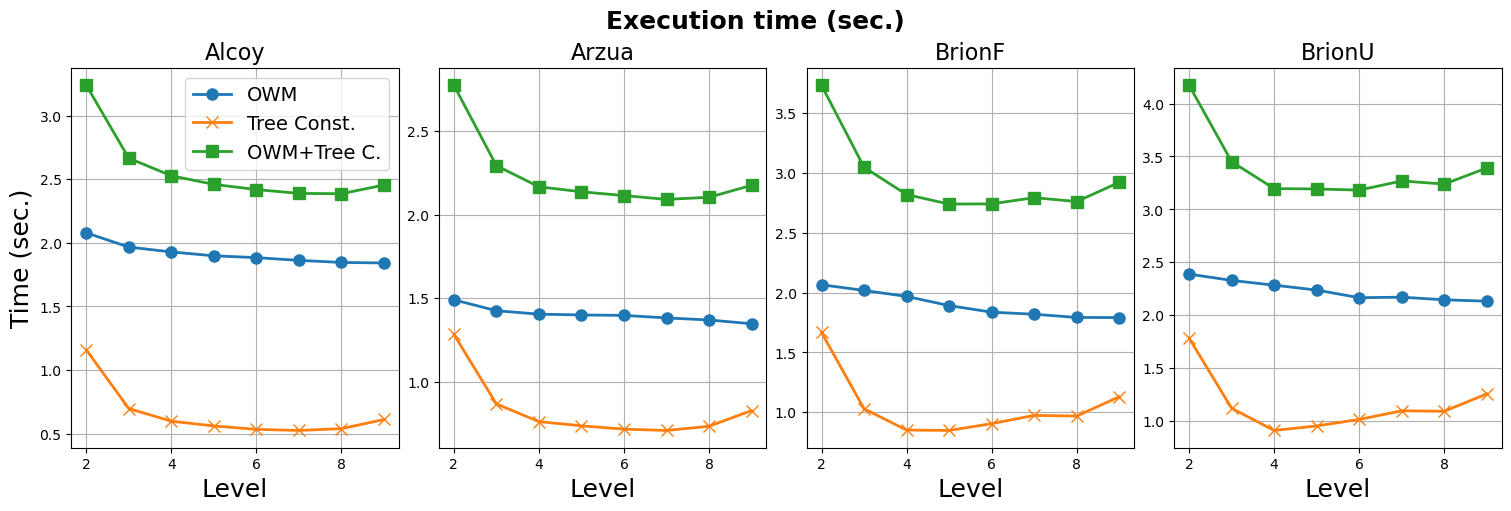

In [55]:
def plot_levels(nth,results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['owm'] for j in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree'] for j in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth]['qtree']+results[name][j][nth]['owm'] for j in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Level', fontsize=xlabelfs)
        axs[i].set_xticks(x[::2],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()


plot_levels(1,res4)
plot_levels(8,res4)


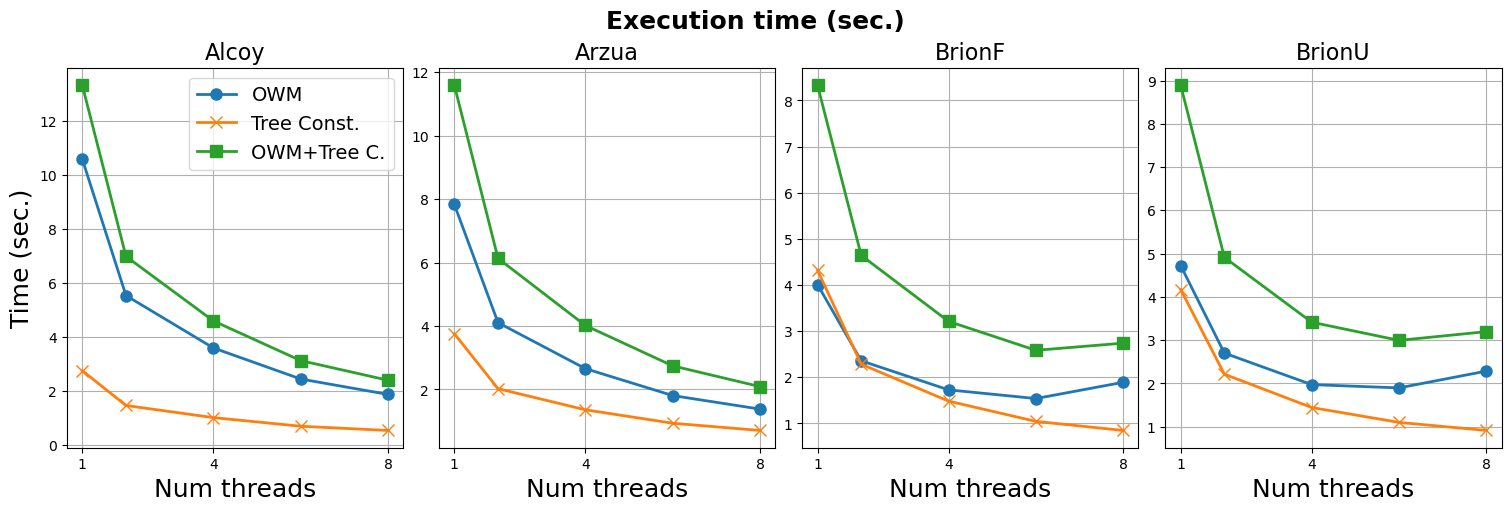

In [61]:
def plot_times_index(results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        bestlevel=min(results[name], key=lambda x: results[name][x][8]['qtree'])
        x=list(results[name][bestlevel].keys())
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][bestlevel][nth]['qtree']+results[name][bestlevel][nth]['owm'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x[::2],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_times_index(res4)

In [65]:
def printcomp(nth,res):#best level
    for i in res:
        bestlevel=min(res[i], key=lambda x: res[i][x][nth]['qtree'])
        print("Cloud {} has best level = {}.".format(i, bestlevel))
        print("Cloud {} has sequential OWM-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}.".format(i,res[i][bestlevel][nth]['owm'], res1[i][nth]['owm']/res[i][bestlevel][nth]['owm'] ))    
        print("Cloud {} has sequential OWM-o2 partree time = {:.2f}. Speedup (o2 partree vs o2) = {:.2f}.".format(i,res[i][bestlevel][nth]['owm'], res2[i][nth]['owm']/res[i][bestlevel][nth]['owm'] ))    

printcomp(1,res4)

Cloud Alcoy has best level = 7.
Cloud Alcoy has sequential OWM-o2 partree time = 10.58. Speedup (o2 partree vs o1) = 1.18.
Cloud Alcoy has sequential OWM-o2 partree time = 10.58. Speedup (o2 partree vs o2) = 0.99.
Cloud Arzua has best level = 7.
Cloud Arzua has sequential OWM-o2 partree time = 7.83. Speedup (o2 partree vs o1) = 1.28.
Cloud Arzua has sequential OWM-o2 partree time = 7.83. Speedup (o2 partree vs o2) = 1.03.
Cloud BrionF has best level = 3.
Cloud BrionF has sequential OWM-o2 partree time = 4.23. Speedup (o2 partree vs o1) = 2.62.
Cloud BrionF has sequential OWM-o2 partree time = 4.23. Speedup (o2 partree vs o2) = 1.22.
Cloud BrionU has best level = 3.
Cloud BrionU has sequential OWM-o2 partree time = 4.85. Speedup (o2 partree vs o1) = 2.68.
Cloud BrionU has sequential OWM-o2 partree time = 4.85. Speedup (o2 partree vs o2) = 1.15.


In [66]:
printcomp(8,res4)

Cloud Alcoy has best level = 7.
Cloud Alcoy has sequential OWM-o2 partree time = 1.86. Speedup (o2 partree vs o1) = 1.06.
Cloud Alcoy has sequential OWM-o2 partree time = 1.86. Speedup (o2 partree vs o2) = 1.01.
Cloud Arzua has best level = 7.
Cloud Arzua has sequential OWM-o2 partree time = 1.38. Speedup (o2 partree vs o1) = 1.23.
Cloud Arzua has sequential OWM-o2 partree time = 1.38. Speedup (o2 partree vs o2) = 1.04.
Cloud BrionF has best level = 5.
Cloud BrionF has sequential OWM-o2 partree time = 1.89. Speedup (o2 partree vs o1) = 1.62.
Cloud BrionF has sequential OWM-o2 partree time = 1.89. Speedup (o2 partree vs o2) = 1.15.
Cloud BrionU has best level = 4.
Cloud BrionU has sequential OWM-o2 partree time = 2.28. Speedup (o2 partree vs o1) = 1.70.
Cloud BrionU has sequential OWM-o2 partree time = 2.28. Speedup (o2 partree vs o2) = 1.11.


In [69]:
#using lev=5
lev=5
for i in res1:
    print("Cloud {} has sequential OWM-o1 time = {:.2f}".format(i,res1[i][1]['owm'] ))
for i in res2:
    print("Cloud {} has sequential OWM-o2 time = {:.2f}. Speedup (o2 vs o1) = {:.2f}.".format(i,res2[i][1]['owm'], res1[i][1]['owm']/res2[i][1]['owm'] ))
for i in res4:
    print("Cloud {} has sequential OWM-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}.".format(i,res4[i][lev][1]['owm'], res1[i][1]['owm']/res4[i][lev][1]['owm'] ))    

Cloud Alcoy has sequential OWM-o1 time = 12.48
Cloud Arzua has sequential OWM-o1 time = 10.03
Cloud BrionF has sequential OWM-o1 time = 11.07
Cloud BrionU has sequential OWM-o1 time = 12.98
Cloud Alcoy has sequential OWM-o2 time = 10.52. Speedup (o2 vs o1) = 1.19.
Cloud Arzua has sequential OWM-o2 time = 8.05. Speedup (o2 vs o1) = 1.25.
Cloud BrionF has sequential OWM-o2 time = 5.16. Speedup (o2 vs o1) = 2.14.
Cloud BrionU has sequential OWM-o2 time = 5.56. Speedup (o2 vs o1) = 2.33.
Cloud Alcoy has sequential OWM-o2 partree time = 10.63. Speedup (o2 partree vs o1) = 1.17.
Cloud Arzua has sequential OWM-o2 partree time = 7.91. Speedup (o2 partree vs o1) = 1.27.
Cloud BrionF has sequential OWM-o2 partree time = 4.01. Speedup (o2 partree vs o1) = 2.76.
Cloud BrionU has sequential OWM-o2 partree time = 4.71. Speedup (o2 partree vs o1) = 2.75.


In [70]:
#total 8-core times

for i in res1:
    totalres1=res1[i][8]['qtree']+res1[i][8]['owm']
    print("Cloud {} has 8-core Total-o1 time = {:.2f}".format(i,totalres1 ))
for i in res2:
    totalres1=res1[i][8]['qtree']+res1[i][8]['owm']
    totalres2=res2[i][8]['qtree']+res2[i][8]['owm']
    print("Cloud {} has 8-core Total-o2 time = {:.2f}. Speedup (o2 vs o1) = {:.2f}.".format(i,totalres2, totalres1/totalres2 ))
for i in res4:
    totalres1=res1[i][8]['qtree']+res1[i][8]['owm']
    totalres2=res2[i][8]['qtree']+res2[i][8]['owm']
    bestlevel=min(res4[i], key=lambda x: res4[i][x][8]['qtree'])
    totalres4=res4[i][bestlevel][8]['qtree']+res4[i][bestlevel][8]['owm']
    print("Cloud {} with level {} has 8-core Total-o2 partree time = {:.2f}. Speedup (o2 partree vs o1) = {:.2f}.".format(i,bestlevel, totalres4, totalres1/totalres4 ))
    print("Cloud {} with level {} has 8-core Total-o2 partree time = {:.2f}. Speedup (o2 partree vs o2) = {:.2f}.".format(i,bestlevel, totalres4, totalres2/totalres4 ))



Cloud Alcoy has 8-core Total-o1 time = 5.15
Cloud Arzua has 8-core Total-o1 time = 5.45
Cloud BrionF has 8-core Total-o1 time = 7.09
Cloud BrionU has 8-core Total-o1 time = 8.41
Cloud Alcoy has 8-core Total-o2 time = 4.86. Speedup (o2 vs o1) = 1.06.
Cloud Arzua has 8-core Total-o2 time = 5.28. Speedup (o2 vs o1) = 1.03.
Cloud BrionF has 8-core Total-o2 time = 6.08. Speedup (o2 vs o1) = 1.17.
Cloud BrionU has 8-core Total-o2 time = 6.73. Speedup (o2 vs o1) = 1.25.
Cloud Alcoy with level 7 has 8-core Total-o2 index time = 2.39. Speedup (o2 index vs o1) = 2.16.
Cloud Alcoy with level 7 has 8-core Total-o2 index time = 2.39. Speedup (o2 two-trees vs o2) = 2.03.
Cloud Arzua with level 7 has 8-core Total-o2 index time = 2.09. Speedup (o2 index vs o1) = 2.61.
Cloud Arzua with level 7 has 8-core Total-o2 index time = 2.09. Speedup (o2 two-trees vs o2) = 2.53.
Cloud BrionF with level 5 has 8-core Total-o2 index time = 2.74. Speedup (o2 index vs o1) = 2.59.
Cloud BrionF with level 5 has 8-core T

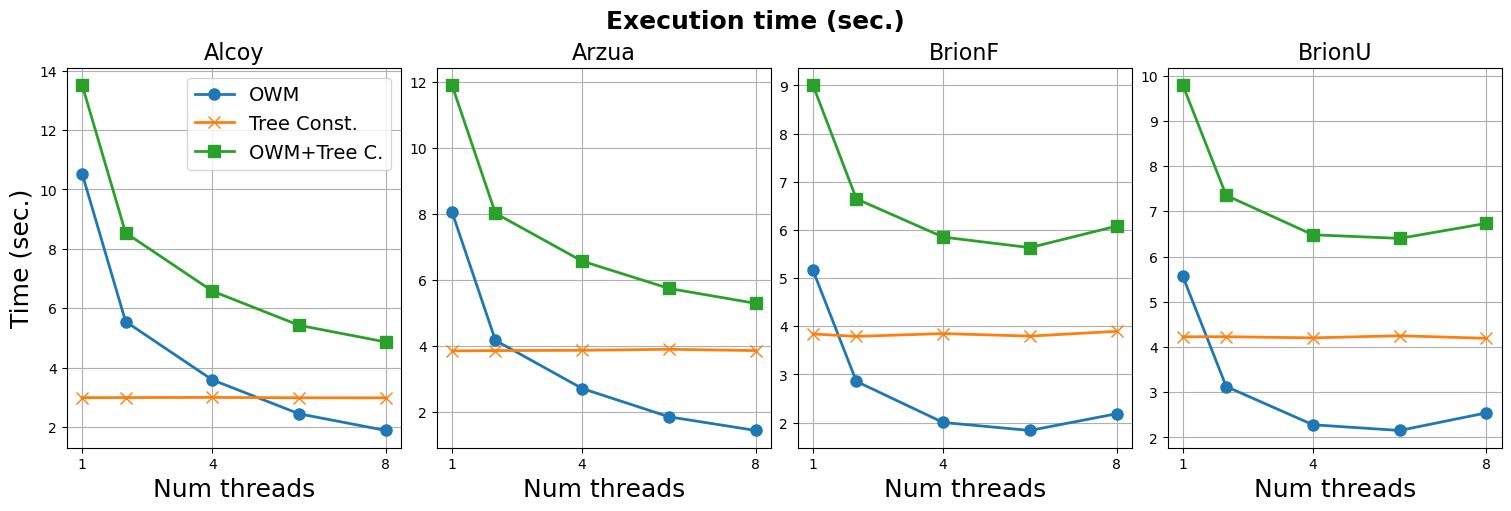

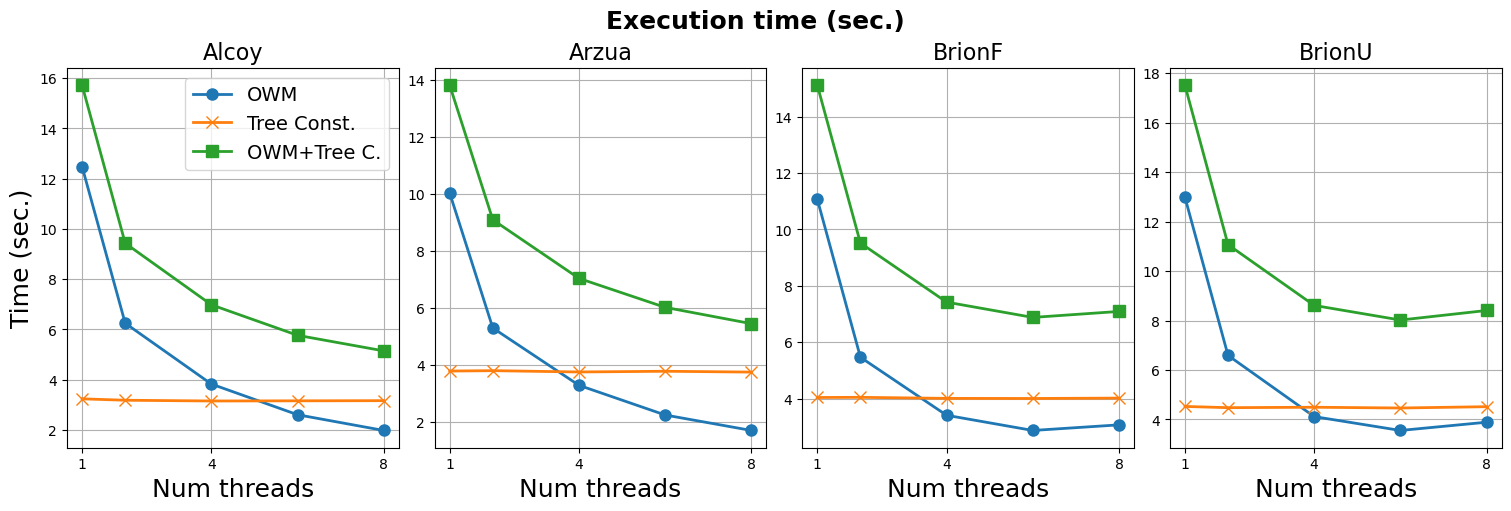

In [11]:
def plot_alltimes(results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][nth]['owm'] for nth in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree'] for nth in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][nth]['qtree']+results[name][nth]['owm'] for nth in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x[::2],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res2)
plot_alltimes(res1)


[1.         1.88918207 2.73556295 4.01679448 5.2159908 ]
[1.         1.85507663 2.76263821 4.01189937 5.30188376]
[1.         1.87858246 2.71938187 3.7920633  4.38021895]
[1.         1.88357374 2.88911989 3.79387419 4.56945515]


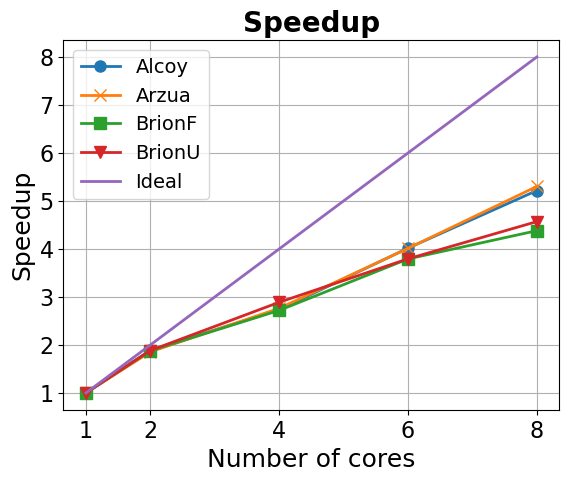

[1.         1.91409374 2.9507242  4.34751482 5.68378868]
[1.         1.90679452 2.94649009 4.32975283 5.66626461]
[1.         1.71303676 2.39102729 2.61805829 2.13160502]
[1.         1.74931395 2.3955978  2.49117531 2.06755852]


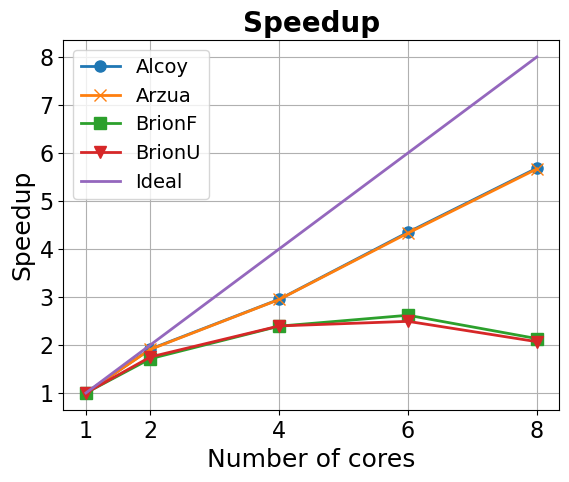

In [71]:
#Configuration variables
def plot_res(phase,res):
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8

    fig = plt.figure()

    marks=['o-','x-','s-','v-','+-']

    for (i,z,lev) in zip(res,marks,[7,7,4,4]):
        print(np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in [1,2,4,6,8]]))
        plt.plot(np.array([1,2,4,6,8]), np.array([res[i][lev][1][phase]/res[i][lev][j][phase] for j in [1,2,4,6,8]]), z, linewidth=linew, markersize=markers)
    plt.plot(np.array([1,2,4,6,8]), np.array([1,2,4,6,8]), '-', linewidth=linew, markersize=markers)

    sizes=[i for i in res]
    sizes.append('Ideal')
    plt.title('Speedup',  fontweight='bold', fontsize=titlefs)
    plt.legend(sizes,loc='best', fontsize= legendfs)
    plt.ylabel('Speedup', fontsize=ylabelfs)
    plt.xlabel('Number of cores', fontsize=xlabelfs)
    plt.xticks([1,2,4,6,8],fontsize=xticksfs)
    plt.yticks(fontsize=yticksfs)
    plt.grid()

    plt.show()

plot_res('qtree',res4)
plot_res('owm',res4)

In [49]:
pp = PdfPages("Speedup-partree.pdf")
pp.savefig(fig)
pp.close()